<a href="https://colab.research.google.com/github/ah20776/CE807---Assignment/blob/main/CE807_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [3]:
df.head(6)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,talk.politics.guns


In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [5]:
#Tokenize and cleanup using Genism Preprocessing

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [6]:
#Lemmatization

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['where s thing subject car nntp post host line wonder out could enlighten car see other day door sport car look late early call door really small addition front bumper separate rest body know can tellme model name engine specs year production where car make history info funky look car mail thank bring neighborhood lerxst', 'poll final call summary final call clock report acceleration post fair number brave soul upgrade si clock oscillator share experience poll send brief message detail experience procedure top speed attain cpu rate speed add card adapter heat sink hour usage day floppy disk functionality floppy especially request will summarize next day so add network knowledge base do clock upgrade answer poll thank']


In [7]:
#Create the Document-Word matrix

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [8]:
#Check the Sparsicity

# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.8435355668648374 %


In [11]:
# Build LDA Model with sklearn

lda_model = LatentDirichletAllocation(n_components=2,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=2, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [12]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -7737616.6784755085
Perplexity:  1890.9573415168406
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 2,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [13]:
# GridSearch the best LDA model

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [14]:
#How to see the best topic model and its parameters?

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -1597560.265734792
Model Perplexity:  1582.8591983066362


In [32]:
model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_decay', 'param_n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

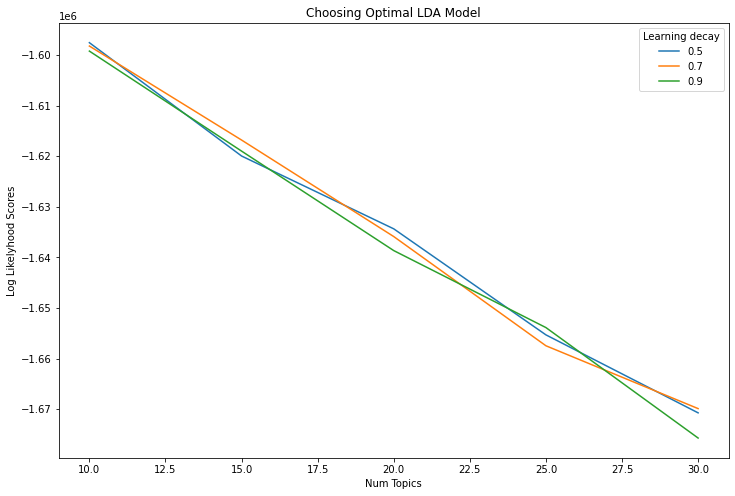

In [37]:
#Compare LDA Model Performance Scores

# Get Log Likelyhoods from Grid Search Output

n_topics = [10, 15, 20, 25, 30]

'''log_likelyhoods_5 = [round(gscore.mean_test_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_test_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_test_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]'''

log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [39]:
#How to see the dominant topic in each document?

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.000000,0.330000,0.000000,6
Doc1,0.000000,0.180000,0.040000,0.000000,0.130000,0.000000,0.000000,0.000000,0.640000,0.000000,8
Doc2,0.130000,0.000000,0.080000,0.000000,0.000000,0.000000,0.220000,0.000000,0.530000,0.040000,8
Doc3,0.280000,0.000000,0.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.380000,0.000000,8
Doc4,0.050000,0.000000,0.000000,0.000000,0.150000,0.000000,0.230000,0.000000,0.100000,0.460000,9
Doc5,0.000000,0.000000,0.000000,0.000000,0.000000,0.570000,0.000000,0.430000,0.000000,0.000000,5
Doc6,0.000000,0.000000,0.000000,0.000000,0.580000,0.000000,0.390000,0.000000,0.000000,0.000000,4
Doc7,0.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.890000,0.000000,8
Doc8,0.010000,0.010000,0.150000,0.010000,0.810000,0.010000,0.010000,0.010000,0.010000,0.010000,4
Doc9,0.000000,0.000000,0.060000,0.000000,0.270000,0.000000,0.000000,0.000000,0.660000,0.000000,8


In [40]:
#Review topics distribution across documents

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,8,2724
1,6,1924
2,7,1365
3,4,1365
4,0,1234
5,2,1185
6,9,596
7,1,530
8,5,346
9,3,45


In [42]:
#visualize the LDA model with pyLDAvis
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.sklearn

     |████████████████████████████████| 1.7MB 6.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 21.2MB/s 
     |████████████████████████████████| 15.3MB 282kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=10ea7a75c56a5cfd8a42a8cc4903ad3af8c6bd10c1ffc5f9b2ab396592b01ebd
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [43]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      32.420952   8.115230       1        1  15.913766
6       0.648955  71.707100       2        1  14.663815
8      71.019684   9.971006       3        1  14.100927
0       3.785981  33.185135       4        1  13.251642
4     -42.666500  -9.222070       5        1  12.831997
5      -3.621689 -43.526516       6        1   8.306841
2      -3.632402  -4.171708       7        1   7.626153
1     -36.584400  35.804413       8        1   6.747996
9      44.391380  50.615383       9        1   5.484430
3      40.235809 -31.591665      10        1   1.072434, topic_info=        Term         Freq        Total Category  logprob  loglift
3906     max  3853.000000  3853.000000  Default  30.0000  30.0000
2496    file  2980.000000  2980.000000  Default  29.0000  29.0000
3609     law  1963.000000  1963.000000  Default  28.0000  28.0000
2702    game  1783.000000  1783.000000  Default  27.0000  27.0000
2880     gun  1660.000000  1660.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
7062    word    54.453620  1350.559793  Topic10  -5.3082   1.3243
3885    mass    39.716120   223.697195  Topic10  -5.6237   2.8067
4851  prayer    35.189524   150.116792  Topic10  -5.7448   3.0846
4038    miss    36.105095   452.818566  Topic10  -5.7191   2.0062
5591     say    39.122172  7038.893644  Topic10  -5.6388  -0.6573

[826 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         1  0.025950     abide
2         4  0.025950     abide
2         6  0.934216     abide
15        1  0.092376  absolute
15        2  0.027371  absolute
...     ...       ...       ...
7107      6  0.108141      year
7107      7  0.302998      year
7107      8  0.158385      year
7107      9  0.043868      year
7109      2  0.995740     yeast

[2537 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 9, 1, 5, 6, 3, 2, 10, 4])

In [44]:
#to see the Topic’s keywords

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abandon,abbreviation,abide,abiding,ability,able,abolish,abomination,abort,abortion,abpsoft,abroad,abs,absence,absent,absolute,absolutely,absorb,abstinence,abstract,absurd,absurdity,abundant,abuse,abusive,abyss,academia,academic,accelerate,accelerated,acceleration,accelerator,accept,acceptable,acceptance,access,accessible,accessory,accident,accidental,...,worthy,wound,wrap,wrath,wreck,wrench,wrist,write,writer,writing,wrong,wrongful,wuarchive,xaw,ximage,xlib,xor,xputimage,xserver,xterm,xview,yard,year,yearly,yeast,yell,yellow,yesterday,yield,young,youngster,yourselfer,youth,zinc,zionism,zionist,zip,zone,zoology,zoom
Topic0,4.540136,0.610106,2.308235,0.100007,104.981641,150.261588,0.100018,0.100007,0.100012,0.100016,0.100000,0.100010,1.027343,25.415314,13.888312,247.351311,61.375626,0.100093,0.538688,10.482983,22.744720,15.877341,6.467156,29.514238,6.028102,0.100001,0.100058,10.799230,0.100013,0.100000,0.100005,0.100008,307.533270,15.035831,44.456501,42.851637,1.546007,0.100000,7.958627,2.231332,...,23.588937,0.100010,0.100007,1.373356,0.100028,0.100000,0.100001,1436.153983,34.104326,70.290801,303.161782,0.100005,0.100000,0.100000,0.100000,0.100000,26.678914,0.100000,0.100000,0.100001,0.100000,0.100004,176.709136,0.100002,0.100010,0.100014,0.100004,7.293315,0.100010,11.065188,0.444671,0.100330,0.100011,0.100004,0.100004,0.100002,0.100001,0.100001,0.100011,0.100003
Topic1,0.100038,0.100012,0.100001,0.100003,1.692155,91.349963,8.270100,0.100001,0.100018,28.422888,0.100000,0.100025,0.100001,0.100030,0.100039,0.100049,24.699726,0.100060,22.681190,0.100029,0.100024,0.100066,0.100029,0.100023,5.879729,0.100921,3.193290,8.017859,0.100005,2.341166,0.100028,3.776621,33.342312,7.275165,0.100015,35.329847,1.660019,0.100013,0.100015,0.100003,...,4.520355,0.100010,25.919198,0.100004,0.100001,0.100007,0.100003,521.254783,17.724536,0.101592,13.461737,0.100002,0.100006,0.100000,0.100000,0.100000,0.100000,0.100000,0.100001,0.100000,0.100001,3.252753,609.754520,0.100261,0.100001,0.698891,0.100009,72.334332,2.220120,69.161265,0.100132,0.100028,21.655981,0.100001,2.963558,7.321219,3.488198,6.621414,23.905814,0.100003
Topic2,2.650253,4.899884,0.100001,0.100000,41.731881,70.566298,0.100004,0.100001,0.100011,0.100002,0.100000,0.100003,0.100146,0.100003,1.243780,0.100027,20.895426,0.100002,0.100000,0.100026,5.016614,0.100077,0.100000,0.100017,0.100010,0.102085,1.296454,0.189346,0.100002,0.100230,0.100005,0.100008,4.152681,3.200834,0.100010,21.450305,1.130231,0.100007,1.552699,0.100002,...,0.764649,2.365247,4.987317,0.100007,0.100244,0.100002,7.977753,1021.629036,16.192237,0.100035,72.792289,0.100005,0.100010,0.100000,0.100000,0.100000,0.100000,0.100000,0.100002,0.100000,0.100000,8.585669,1213.673329,3.281780,0.100000,0.100007,0.100042,38.822189,0.100003,123.638105,6.553595,0.349796,1.673919,0.100002,0.100000,0.100002,0.778922,66.327341,0.100003,0.100038
Topic3,0.100011,0.100000,0.100013,0.100000,0.100009,0.100007,18.326284,0.100001,0.100000,0.100001,0.100000,0.100013,0.100000,0.100027,0.100041,0.100000,0.100007,0.100000,0.100023,0.100000,0.100001,0.100001,0.100000,0.100028,0.100010,0.100000,0.100000,0.100010,0.100006,0.100000,0.100002,0.100000,2.030028,0.100003,0.100000,0.131302,0.100011,0.100000,0.100000,0.101966,...,3.084423,0.100000,0.100000,0.100008,0.100000,0.100000,0.100000,5.687829,5.419408,0.100012,0.100009,0.100001,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100003,0.283257,0.100000,0.100036,0.100020,0.100001,0.100001,0.100012,0.100011,0.100040,0.100000,0.100003,0.100000,0.100000,0.100001,0.100014,0.100001,0.100000,0.100000
Topic4,5.490178,5.692788,0.100001,0.100002,32.109285,129.931543,0.100002,0.100000,13.320013,0.100004,8.635251,0.100001,0.100012,0.108593,0.546345,3.535183,1.866044,1.566175,0.100000,36.934857,0.100006,0.100014,0.100001,3.086183,9.150097,0.100006,3.454714,28.965564,0.100016,0.100013,16.414580,50.942367,69.348109,16.991023,11.436254,351.480694,17.782592,7.253185,0.100004,0.100003,...,0.

In [45]:
#Get the top 15 keywords each topic

def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,say,key,write,know,believe,think,line,make,use,people,just,good,question,thing,subject
Topic 1,say,make,space,year,work,think,people,write,know,line,money,just,israeli,article,job
Topic 2,game,team,line,year,play,write,win,player,good,post,article,think,subject,season,make
Topic 3,max,law,day,worship,sin,church,faith,bhj,commandment,link,jewish,allocation,prophecy,word,christian
Topic 4,use,window,file,line,program,post,available,mail,information,run,include,software,list,version,server
Topic 5,gun,use,law,government,weapon,public,control,encryption,technology,firearm,year,crime,new,police,protect
Topic 6,write,line,say,article,just,know,subject,post,time,think,people,make,thing,good,come
Topic 7,people,write,say,right,article,think,make,line,know,government,state,kill,just,child,way
Topic 8,line,use,drive,post,write,card,subject,work,problem,know,good,article,need,just,driver
Topic 9,file,line,write,use,color,program,post,image,entry,output,subject,article,bit,point,value


In [49]:
#How to predict the topics for a new piece of text

# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about cars and bikes"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(prob_scores)

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


['write', 'line', 'say', 'article', 'just', 'know', 'subject', 'post', 'time', 'think', 'people', 'make', 'thing', 'good', 'come']
[[0.0250101  0.025      0.025      0.025      0.02500724 0.02500197
  0.52499436 0.02500097 0.02500582 0.27497955]]


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
